In [ ]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as shc

In [ ]:
df = pd.read_csv('/content/yeast.data',header = None, names = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox','vac', 'nuc','local'])

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


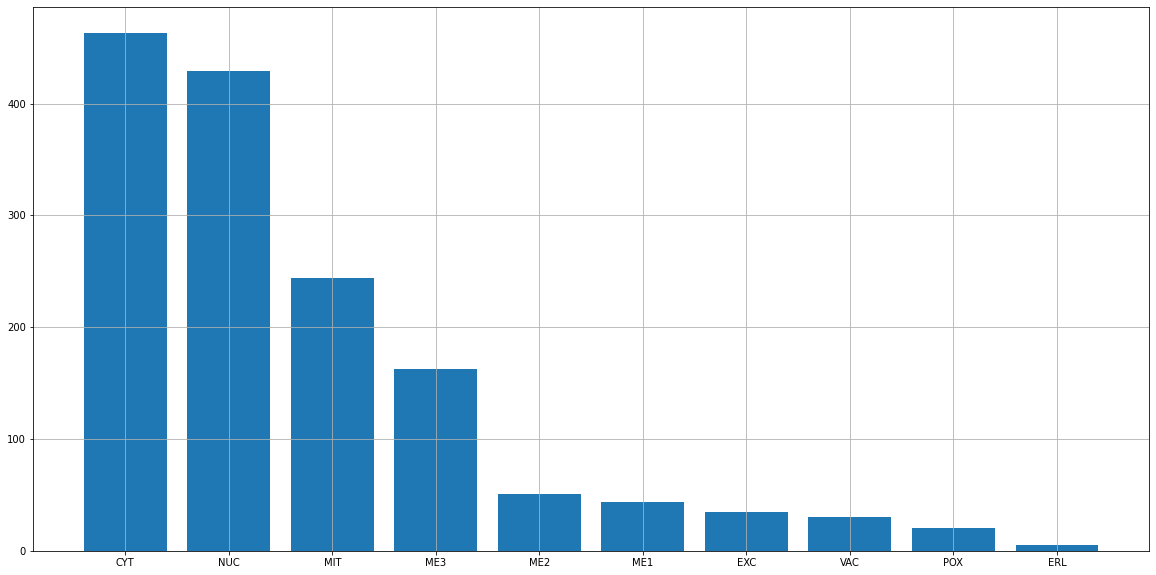

In [ ]:
#Class distribution 
plt.figure(figsize=(20, 10))
plt.grid()
plt.bar(df.value_counts('local').index, df.value_counts('local').values);

In [ ]:
#Separating target (y) from features (x)
x = df.drop(columns = 'local')
y = df['local']

In [ ]:
distortions = []
K = range(1,51)
#Training KMeans using value range of [1, 50]
for k in K:
    kmeansElbow_model = KMeans(n_clusters=k)
    kmeansElbow_model.fit(x)
    #cdist() -> Applies Euclidean distance between each data and each calculated centroid 
    #np.min() -> Selects the distance between each data and its nearest centroid 
    #sum() -> Sum of Euclidean distances between each data and its respective centroid 
    distortions.append(sum(np.min(cdist(x,kmeansElbow_model.cluster_centers_,"euclidean"),axis=1))/x.shape[0])

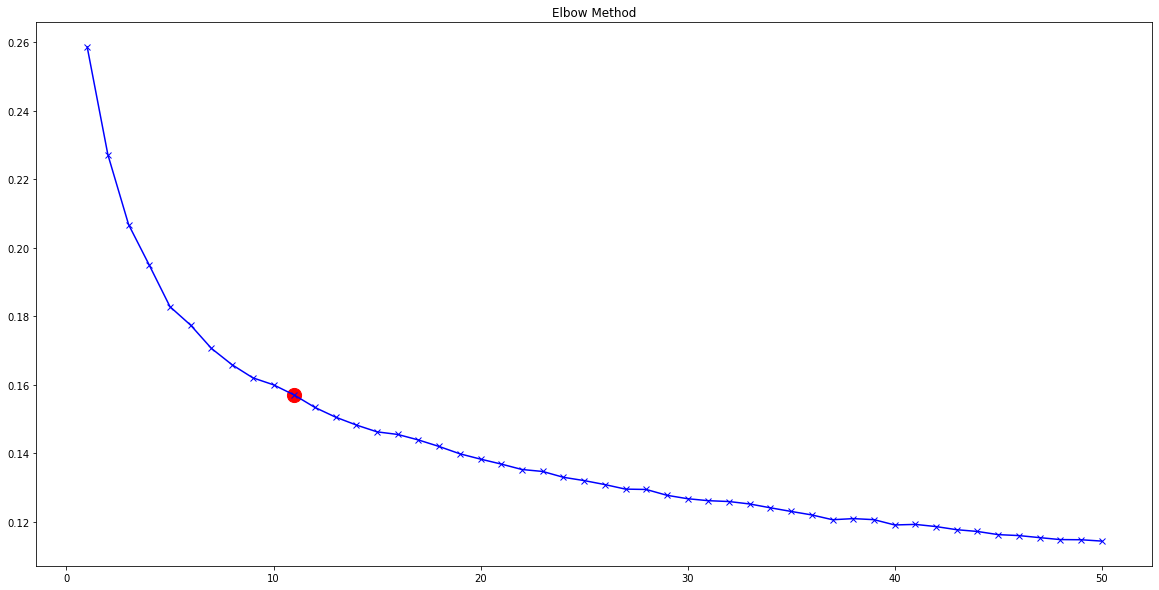

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Elbow Method")
#Plotting for change in K value
plt.plot(K,distortions,'bx-')
#marker
plt.scatter(11, distortions[10], marker="o", s = 200, c = "red")

In [ ]:
#Training KMeans with 11 centroids
nclusters = 11
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(x)

In [ ]:
pred = kmeans.predict(x)

In [ ]:
df["Results"] = pred

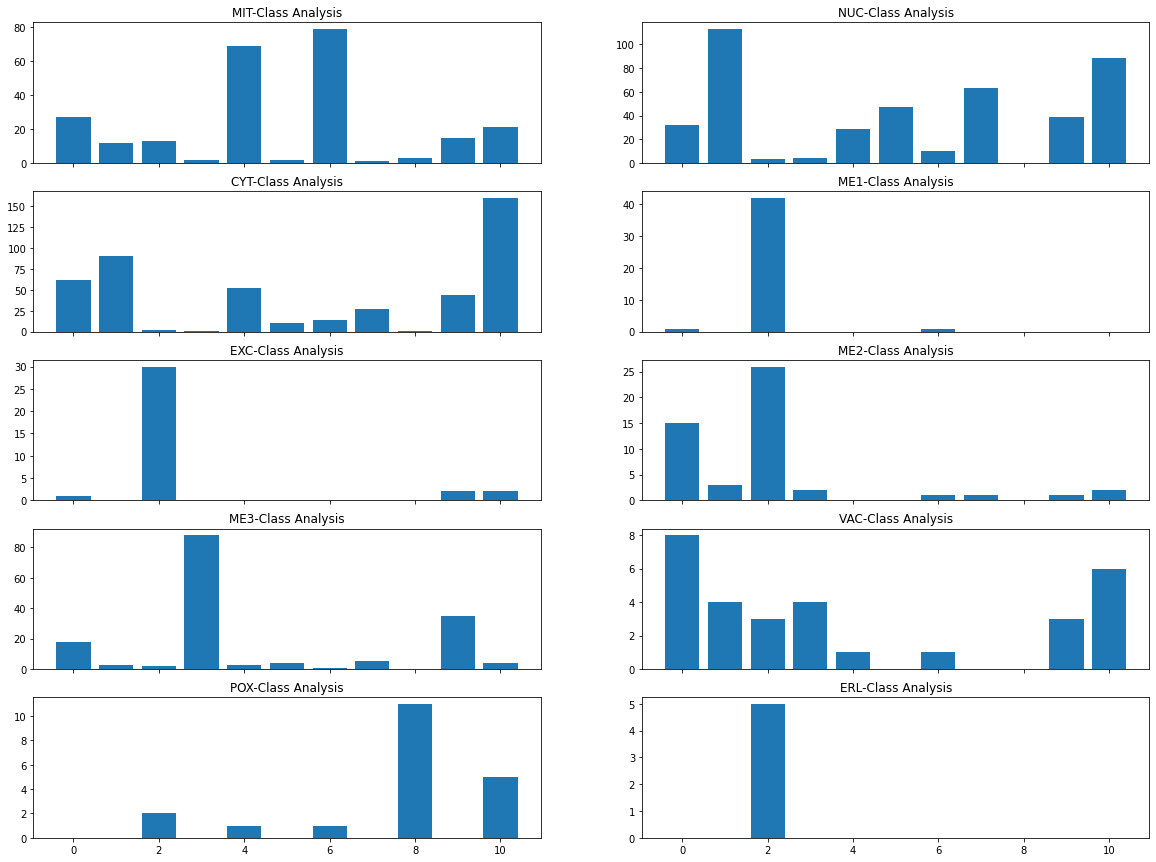

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(20,15), sharex=True)
cont = 0

for classe in df['local'].drop_duplicates():
  axs[int(cont/2), cont%2].set_title(classe + "-Class Analysis")
  axs[int(cont/2), cont%2].bar(df.loc[df['local'] == classe].value_counts('Results').index, df.loc[df['local'] == classe].value_counts('Results').values)
  cont = cont + 1

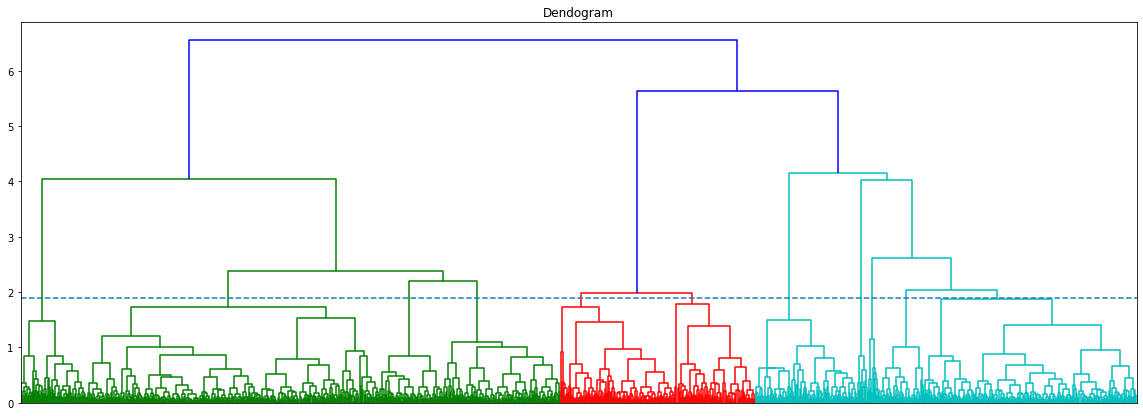

In [ ]:
plt.figure(figsize=(20, 7))
plt.title("Dendogram")
plt.axhline(y=1.9, ls="--")
dend = shc.dendrogram(shc.linkage(x, method='ward'), no_labels = True)

In [ ]:
xSOM = x.to_numpy()

In [ ]:
!pip install MiniSom

In [ ]:
from minisom import MiniSom

In [ ]:
som = MiniSom(10, 10, xSOM.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(xSOM)
som.train(xSOM, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.10810316761761538


In [ ]:
def calcIntensity(w):
  coords, counts = np.unique(w, return_counts=True, axis=0)
  coord_x = coords[:, 0]
  coord_y = coords[:, 1]
  intensity = counts / counts.sum()
  return coord_x, coord_y, intensity

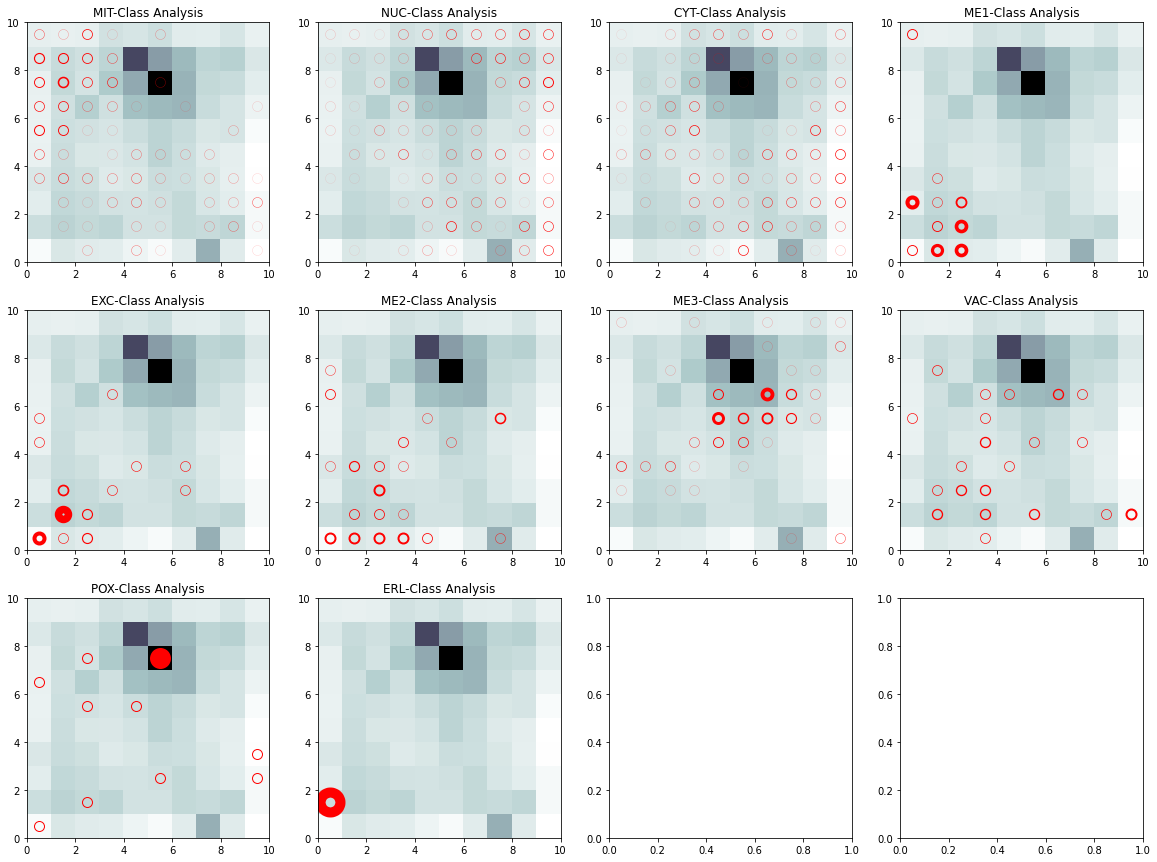

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20,15))
cont = 0

for classe in df['local'].drop_duplicates():
  axs[int(cont/4), cont%4].set_title(classe + "-Class Analysis")
  axs[int(cont/4), cont%4].pcolor(som.distance_map().T, cmap='bone_r')
  w = [som.winner(dado) for dado in xSOM[df["local"] == classe]]
  x_points, y_points, intensity = calcIntensity(w)
  for i in range(len(intensity)):
    axs[int(cont/4), cont%4].plot(x_points[i] + 0.5, y_points[i] + 0.5, "o", markerfacecolor='None', markeredgecolor="red", markersize = 10, markeredgewidth= 20 * intensity[i])
  cont = cont + 1